# Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img , ImageDataGenerator
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Data Loading

In [4]:
# Paths to images
covid_image_path = './COVID-19_Radiography_Dataset/COVID/images/'
normal_image_path = './COVID-19_Radiography_Dataset/Normal/images/'
pneumonia_image_path = './COVID-19_Radiography_Dataset/Viral Pneumonia/images/'
lung_opacity_image_path = './COVID-19_Radiography_Dataset/Lung_Opacity/images/'

# Paths to masks
covid_mask_path = './COVID-19_Radiography_Dataset/COVID/masks/'
normal_mask_path = './COVID-19_Radiography_Dataset/Normal/masks/'
pneumonia_mask_path = './COVID-19_Radiography_Dataset/Viral Pneumonia/masks/'
lung_opacity_mask_path = './COVID-19_Radiography_Dataset/Lung_Opacity/masks/'

# All paths to images and masks
all_image_paths = [[covid_image_path+file for file in os.listdir(covid_image_path)]
                   +[normal_image_path+file for file in os.listdir(normal_image_path)]
                   +[pneumonia_image_path+file for file in os.listdir(pneumonia_image_path)]
                   +[lung_opacity_image_path+file for file in os.listdir(lung_opacity_image_path)]
                  ][0]
all_mask_paths = [[covid_mask_path+file for file in os.listdir(covid_mask_path)]
                  +[normal_mask_path+file for file in os.listdir(normal_mask_path)]
                  +[pneumonia_mask_path+file for file in os.listdir(pneumonia_mask_path)]
                  +[lung_opacity_mask_path+file for file in os.listdir(lung_opacity_mask_path)]
                 ][0]

# Shuffle the arrays
all_image_paths, all_mask_paths = shuffle(all_image_paths, all_mask_paths)

# Data Visualization

In [5]:
IMAGE_SIZE = 256

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.mean(image, axis=-1)/255.0
        images.append(image)
    return np.array(images)
def plot_sample(n):
    fig = plt.figure(figsize=(12, 12))
    plt.subplot(1,3,1)
    plt.imshow(open_images([all_image_paths[n]])[0], cmap='gray', interpolation='none')
    plt.subplot(1,3,2)
    plt.imshow(open_images([all_mask_paths[n]])[0],cmap='bone')
    plt.subplot(1,3,3)
    plt.imshow(open_images([all_image_paths[n]])[0], cmap='gray', interpolation='none')
    plt.imshow(open_images([all_mask_paths[n]])[0], cmap='Spectral', alpha=0.4)
    plt.axis('off')
    plt.show()

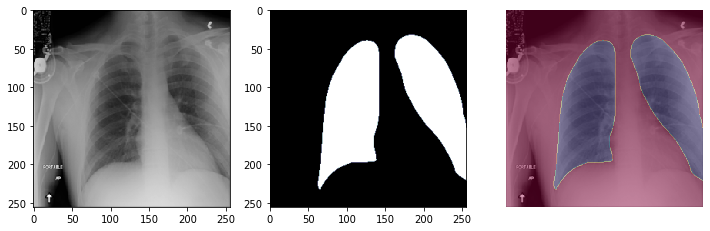

In [6]:
plot_sample(500)

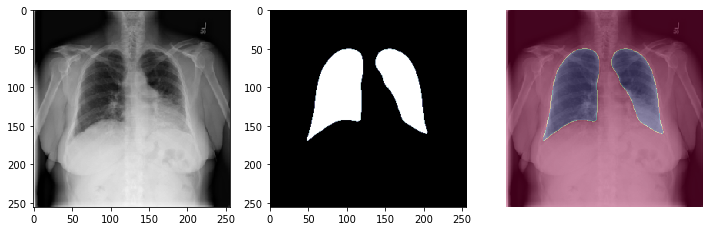

In [7]:
plot_sample(8000)

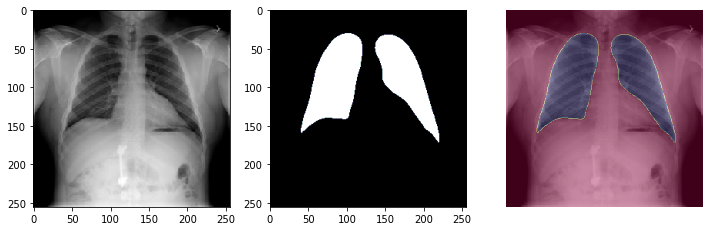

In [8]:
plot_sample(9500)

#Data Preprocessing

In [9]:
num_train=int(len(all_image_paths)*0.8)
print('num_train=',num_train)
print('num_test=',len(all_image_paths)-num_train)
train_image_paths = all_image_paths[:num_train]
train_mask_paths = all_mask_paths[:num_train]
val_image_paths = all_image_paths[num_train:]
val_mask_paths = all_mask_paths[num_train:]

num_train= 16932
num_test= 4233


In [10]:
batch_size=16
gen=ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
		height_shift_range=0.2
    )
def datagen(image_paths, mask_paths, batch_size=16):
    for x in range(0, len(image_paths), batch_size):
        images = open_images(image_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        masks = open_images(mask_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        gen.fit(images,seed=40)
        gen.fit(masks,seed=40)
        yield images, masks

# IoU (Intersection over Union) 

In [11]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

## UNet Model

In [12]:
img_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x1 = Conv2D(64, (3,3), activation='relu', padding='same')(img_input)
x1 = Conv2D(64, (3,3), activation='relu', padding='same')(x1)
x1_pool = MaxPool2D((2,2))(x1)

x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x1_pool)
x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x2)
x2_pool = MaxPool2D((2,2))(x2)

x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x2_pool)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3_pool = MaxPool2D((2,2))(x3)

x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x3_pool)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4_pool = UpSampling2D((2,2))(x4)

x5 = Concatenate()([x4_pool, x3])
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5_pool = UpSampling2D((2,2))(x5)

x6 = Concatenate()([x5_pool, x2])
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6_pool = UpSampling2D((2,2))(x6)

x7 = Concatenate()([x6_pool, x1])
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x7)

model = Model(img_input, x7)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[iou_coef])

## Training

In [15]:
batch_size = 20
steps = int(len(train_image_paths)/batch_size)
epochs = 5
for _ in range(epochs):
    model.fit(datagen(train_image_paths, train_mask_paths, batch_size=batch_size), epochs=1, steps_per_epoch=steps)

846/846 [==============================] - 572s 676ms/step - loss: 0.0213 - iou_coef: 0.9457


## Evaluation

In [16]:
batch_size = 20
steps = int(len(val_image_paths)/batch_size)
model.evaluate(datagen(val_image_paths, val_mask_paths, batch_size=batch_size), steps=steps)

211/211 [==============================] - 53s 250ms/step - loss: 0.0230 - iou_coef: 0.9480


[0.022992713376879692, 0.9480414390563965]